# How to Use FJD

This notebook provides a simple example of how to evaluate a conditional GAN using FJD.

In [1]:
%matplotlib inline
import numpy as np

import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from fjd_metric import FJDMetric
from embeddings import OneHotEmbedding, InceptionEmbedding

In order to compute FJD we will need two data loaders: one to provide images and conditioning for the reference distribution, and a second one whose conditioning will be used to condition the GAN for creating the generated distribution. For this example we will use the CIFAR-10 dataset.

When loading in reference images, it is important to normalize them between [-1, 1].

In [2]:
def get_dataloaders():
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                              std=(0.5, 0.5, 0.5))])

    train_set = CIFAR10(root='./datasets/cifar10',
                        train=True,
                        download=True,
                        transform=transform)

    test_set = CIFAR10(root='./datasets/cifar10',
                       train=False,
                       download=True,
                       transform=transform)

    train_loader = DataLoader(train_set,
                              batch_size=128,
                              shuffle=True,
                              drop_last=False,
                              num_workers=2)

    test_loader = DataLoader(test_set,
                             batch_size=128,
                             shuffle=False,
                             drop_last=False,
                             num_workers=2)

    return train_loader, test_loader

To simulate a GAN we will use samples from the test set. Note that the labels from the test set are shuffled, so although the image distribution should match the reference distribution well, the conditional consistency will be very bad since most of the "generated" images will not match the requested conditions.

In [3]:
class SuspiciouslyGoodGAN(torch.nn.Module):
    def __init__(self):
        super(SuspiciouslyGoodGAN, self).__init__()

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                 std=(0.5, 0.5, 0.5))])

        test_set = CIFAR10(root='./datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform)

        test_loader = DataLoader(test_set,
                                 batch_size=128,
                                 shuffle=True,
                                 drop_last=False,
                                 num_workers=2)

        self.test_loader = test_loader
        self.data_iter = iter(test_loader)

    def forward(self, z, y):
        # Normally a GAN would actually do something with z and y, but for this fake GAN we ignore them
        try:
            samples, _ = next(self.data_iter)
        except StopIteration:
            # Reset dataloader if it runs out of samples
            self.data_iter = iter(self.test_loader)
            samples, _ = next(self.data_iter)
        samples = samples.cuda()
        return samples

In order to be able to accomodate a wide variety of model configurations, we use a GAN wrapper to standardize model inputs and outputs. Each model is expected to take as input a set of conditions _y_, and return a corresponding set of generated samples.

In [4]:
class GANWrapper:
    def __init__(self, model, model_checkpoint=None):
        self.model = model
        
        if model_checkpoint is not None:
            self.model_checkpoint = model_checkpoint
            self.load_model()

    def load_model(self):
        # self.model.eval()  # uncomment to put in eval mode if desired
        self.model = self.model.cuda()

        state_dict = torch.load(self.model_checkpoint)
        self.model.load_state_dict(state_dict)

    def get_noise(self, batch_size):
        # change the noise dimension as required
        z = torch.cuda.FloatTensor(batch_size, 128).normal_()
        return z

    def __call__(self, y):
        batch_size = y.size(0)
        z = self.get_noise(batch_size)
        samples = self.model(z, y)
        return samples

The FJDMetric object handles embedding the images and conditioning, the computation of the reference distribution and generated distribution statistics, the scaling of the conditioning component with alpha, and the calculation of FJD. It requires several inputs:

1. **gan** - A GAN model which takes as input conditioning and yields image samples as output.  
2. **reference_loader** - A data loader for the reference distribution, which yields image-condition pairs.  
3. **condition_loader** - A data loader for the generated distribution, which yields image-condition pairs. Images are ignored, and the conditioning is used as input to the GAN.  
4. **image_embedding** - An image embedding function. This will almost always be the InceptionEmbedding.  
5. **condition_embedding** - A conditioning embedding function. As we are dealing with class conditioning in this example, we will use one-hot encoding.

Other options:
* **save_reference_stats** - Indicates whether the statistics of the reference distribution should be saved to the path provided in **reference_stats_path**. This can speed up computation of FJD if the same reference set is used for multiple evaluations.
* **samples_per_condition** - Indicates the number of images that will be generated for each condition drawn from the condition loader. This may be useful if there are very few samples in the conditioning dataset, or to emphasize intra-conditioning diversity when calculating FJD.
* **cuda** - If True, indicates that the GPU accelerated version of FJD should be used. This version should be considerably faster than the CPU version, but may be slightly more unstable.

In [5]:
train_loader, test_loader = get_dataloaders()
inception_embedding = InceptionEmbedding(parallel=False)
onehot_embedding = OneHotEmbedding(num_classes=10)
gan = SuspiciouslyGoodGAN()
gan = GANWrapper(gan)

fjd_metric = FJDMetric(gan=gan,
                       reference_loader=train_loader,
                       condition_loader=test_loader,
                       image_embedding=inception_embedding,
                       condition_embedding=onehot_embedding,
                       reference_stats_path='datasets/cifar_train_stats.npz',
                       save_reference_stats=True,
                       samples_per_condition=1,
                       cuda=True)

  0%|          | 729088/170498071 [00:00<00:23, 7267046.37it/s]

170500096it [00:08, 20917536.96it/s]                               


Extracting ./datasets/cifar10/cifar-10-python.tar.gz to ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified


Once the FJD object is initialized, FID and FJD can be calculated by calling **get_fid** or **get_fjd**.  By default, the alpha value used to weight the conditional component of FJD is selected to be the ratio between the average L2 norm of the image embedding and conditioning embedding.  

We see in this example that even though our "GAN" gets a very good FID score due to the generated image distribution being very close to the reference image distribution, its FJD score is very bad, as the model lacks any conditional consistency.

In [6]:
fid = fjd_metric.get_fid()
fjd = fjd_metric.get_fjd()
print('FID: ', fid)
print('FJD: ', fjd)

Computing generated distribution: 100%|██████████| 79/79 [00:21<00:00,  3.65it/s]


FID:  3.071923078837756
FJD:  33.47266611128043


To visualize how FJD changes as we increase the weighting on the conditional component, we can evaluate it at a range of alpha values using the **sweep_alpha** function.

Computing generated distribution: 100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


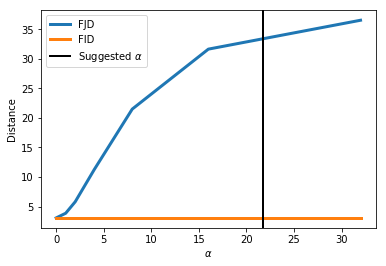

In [7]:
alpha = fjd_metric.alpha
alphas = [0, 1, 2, 4, 8, 16, 32]
fjds = fjd_metric.sweep_alpha(alphas)

plt.plot(alphas, fjds, label='FJD', linewidth=3)
plt.plot(alphas, [fid]*len(alphas), label='FID', linewidth=3)
plt.axvline(x=alpha, c='black', label=r'Suggested $\alpha$', linewidth=2)
plt.xlabel(r'$\alpha$')
plt.ylabel('Distance')
plt.legend()